In [1]:
import warnings
warnings.filterwarnings("ignore")  # Globally suppress warnings

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [2]:
# load data 
df = pd.read_csv("train_ml_ops.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   uid                         10000 non-null  float64
 1   city                        10000 non-null  object 
 2   homeType                    10000 non-null  object 
 3   latitude                    10000 non-null  float64
 4   longitude                   10000 non-null  float64
 5   garageSpaces                10000 non-null  float64
 6   hasSpa                      10000 non-null  object 
 7   yearBuilt                   10000 non-null  float64
 8   numOfPatioAndPorchFeatures  10000 non-null  float64
 9   lotSizeSqFt                 10000 non-null  float64
 10  avgSchoolRating             10000 non-null  float64
 11  MedianStudentsPerTeacher    10000 non-null  float64
 12  numOfBathrooms              10000 non-null  float64
 13  numOfBedrooms               100

In [3]:
# missing data 
df.isna().sum()
df = df[~df.isnull().any(axis=1)]

# drop uid 
df = df.drop(columns=["uid"])

# categories data
df.city.unique()
df.homeType.unique()
df.hasSpa.unique()
df.priceRange.unique()

# Convert 'hasSpa' to binary 1/0, robust to True/False, "True"/"False", and NaN
df.hasSpa = df.hasSpa.astype(str).str.lower().map({"true": 1, "false": 0})

# Label encode categorical variables
label_encoders = {}

# Encode 'city'
city_le = LabelEncoder()
df['city'] = city_le.fit_transform(df['city'])
label_encoders['city'] = city_le

# Encode 'homeType'
home_type_le = LabelEncoder()
df['homeType'] = home_type_le.fit_transform(df['homeType'])
label_encoders['homeType'] = home_type_le

# Encode 'priceRange'
price_range_le = LabelEncoder()
df['priceRange'] = price_range_le.fit_transform(df['priceRange'])
label_encoders['priceRange'] = price_range_le

In [17]:
# # look distribution 

# df.hist(bins=30, figsize=(10, 8))
# plt.suptitle("Feature Distributions")
# plt.show()

1. right-skewed: garageSpaces, lotSizeSqFt, numOfPatioAndPorchFeatures, numOfBathrooms, numOfBedrooms
2. latitude and longitude show a good spread 
3. avgSchoolRating, MedianStudentsPerTeacher, yearBuilt look normally distributed enough 
4. priceRange is somewhat balanced — good for classification.

In [18]:
# # correleration 

# corr = df.corr(numeric_only=True)
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# plt.title("Feature Correlation Matrix")
# plt.show()


1. Strong Positive Correlations with priceRange
- avgSchoolRating → 0.50
- numOfBathrooms → 0.47
- numOfBedrooms → 0.35
- MedianStudentsPerTeacher → 0.39

2. Multicollinearity Concerns

- numOfBathrooms vs. numOfBedrooms → 0.64
- avgSchoolRating vs. MedianStudentsPerTeacher → 0.74

3. Weak or Negative Correlations with priceRange

- longitude: −0.34
- city, homeType: ~0.06
- lotSizeSqFt: Very weak correlation (−0.01) despite being a big number
- longitude might still be useful when combined with latitude.

#### baseline 

In [6]:
# Separate features and target
X = df.drop(columns=["priceRange"])
y = df["priceRange"]

In [7]:
print("\nFinal X shape:", X.shape)
print("Target y distribution:\n", y.value_counts())


Final X shape: (10000, 13)
Target y distribution:
 priceRange
1    2356
2    2301
3    2275
4    1819
0    1249
Name: count, dtype: int64


In [19]:
# # Plot target distribution

# plt.figure(figsize=(6, 3))
# sns.countplot(x=y, order=y.value_counts().index)
# plt.title("Distribution of Target: priceRange")
# plt.xlabel("Price Range (Encoded)")
# plt.ylabel("Count")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 15
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


In [9]:
#  Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Train Baseline Model (random forest) 
from sklearn.ensemble import RandomForestClassifier
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
# Evaluate Model
y_pred = baseline_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Baseline Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Baseline Accuracy: 0.6305
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.55      0.63       250
           1       0.59      0.63      0.61       471
           2       0.53      0.55      0.54       460
           3       0.61      0.64      0.62       455
           4       0.81      0.77      0.79       364

    accuracy                           0.63      2000
   macro avg       0.65      0.63      0.64      2000
weighted avg       0.64      0.63      0.63      2000



- A baseline accuracy of ~63% is a good starting point, especially for a multi-class problem with 5 classes.
- Class 4 performs best — high precision and recall
- Class 2 underperforms — likely needs more representative data or refined features
- Some class imbalance may be impacting the model

#### Train Model with Class Weights 

In [10]:
# Define X and y
X = df.drop(columns=["priceRange"])
y = df["priceRange"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Model with Class Weights
weighted_model = RandomForestClassifier(random_state=42, class_weight="balanced")
weighted_model.fit(X_train, y_train)
# Evaluate and Compare
y_pred = weighted_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("✅ Accuracy with class_weight='balanced':", accuracy)

print("\n📋 Classification Report (Weighted Model):")
print(classification_report(y_test, y_pred))


✅ Accuracy with class_weight='balanced': 0.628

📋 Classification Report (Weighted Model):
              precision    recall  f1-score   support

           0       0.71      0.58      0.64       250
           1       0.58      0.63      0.60       471
           2       0.54      0.54      0.54       460
           3       0.60      0.64      0.62       455
           4       0.80      0.77      0.78       364

    accuracy                           0.63      2000
   macro avg       0.65      0.63      0.64      2000
weighted avg       0.63      0.63      0.63      2000



- Test LogisticRegression, XGBoost, or HistGradientBoostingClassifier
- Tune hyperparameters with GridSearchCV

#### Compare Multiple Classifiers with GridSearchCV

In [11]:
X = df.drop(columns=["priceRange"])
y = df["priceRange"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

models = {
    "LogisticRegression": (LogisticRegression(max_iter=1000, class_weight="balanced"),
                           {"C": [0.1, 1, 10]}),

    "HistGradientBoosting": (HistGradientBoostingClassifier(),
                             {"learning_rate": [0.01, 0.1], "max_iter": [100, 200]}),

    "XGBoost": (XGBClassifier(objective="multi:softmax", num_class=len(set(y)), eval_metric="mlogloss"),
                {"max_depth": [3, 5], "learning_rate": [0.05, 0.1]})
}

for name, (model, param_grid) in models.items():
    print(f"\n Tuning {name}...")
    grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"\n Best params for {name}: {grid.best_params_}")
    print(f" Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f" Classification Report:\n{classification_report(y_test, y_pred)}")



 Tuning LogisticRegression...


/Users/Pi/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Pi/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode


 Best params for LogisticRegression: {'C': 0.1}
 Accuracy: 0.3805
 Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.60      0.42       250
           1       0.41      0.33      0.37       471
           2       0.32      0.20      0.25       460
           3       0.34      0.35      0.34       455
           4       0.51      0.57      0.54       364

    accuracy                           0.38      2000
   macro avg       0.38      0.41      0.38      2000
weighted avg       0.38      0.38      0.37      2000


 Tuning HistGradientBoosting...

 Best params for HistGradientBoosting: {'learning_rate': 0.1, 'max_iter': 100}
 Accuracy: 0.6370
 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.57      0.65       250
           1       0.60      0.64      0.62       471
           2       0.53      0.53      0.53       460
           3       0.62      0.66      0.64     

- HistGradientBoosting	0.6370	✅ Best accuracy; strong across all classes
- XGBoost	0.6365	✅ Nearly identical to HGB; great class 4 recall
- Random Forest	0.6310	Solid baseline with feature selection
- Logistic Regression	0.3805	❌ Underperformed due to scale sensitivity and data non-linearity

#### To improve your HistGradientBoostingClassifier, you can tune several hyperparameters such as:

- learning_rate: step size (lower often generalizes better)
- max_iter: number of boosting iterations
- max_leaf_nodes: complexity of individual trees
- min_samples_leaf: minimum samples per leaf
- l2_regularization: regularization strength

## feature engineering
- Option 1: SelectKBest (statistical test-based)
- Option 2: feature_importances_ from RandomForest

In [12]:
X = df.drop(columns=["priceRange"])
y = df["priceRange"]

# Apply SelectKBest with ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=10)
X_kbest = selector.fit_transform(X, y)
kbest_features = X.columns[selector.get_support()]
print("Top 10 features using SelectKBest:")
print(kbest_features.tolist())

# Train Random Forest to extract feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
# Get and sort feature importances
importances = rf.feature_importances_
rf_ranking = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("\nTop 10 features using RandomForest:")
print(rf_ranking.head(10))

# Compare and Merge Results
combined_top_features = sorted(set(kbest_features).union(rf_ranking.head(10).index))
print("\n Combined Top Features (Union):")
print(combined_top_features)

# choose those top 10 feature columns 
X = X[combined_top_features]

# Add Interaction Features
X['rating_per_teacher'] = X['avgSchoolRating'] / (X['MedianStudentsPerTeacher'] + 1)
X['area_per_bed'] = X['lotSizeSqFt'] / (X['numOfBedrooms'] + 1)
X['garage_per_bath'] = X['garageSpaces'] / (X['numOfBathrooms'] + 1)

Top 10 features using SelectKBest:
['city', 'latitude', 'longitude', 'garageSpaces', 'hasSpa', 'numOfPatioAndPorchFeatures', 'avgSchoolRating', 'MedianStudentsPerTeacher', 'numOfBathrooms', 'numOfBedrooms']

Top 10 features using RandomForest:
latitude                      0.185383
longitude                     0.180566
lotSizeSqFt                   0.153869
yearBuilt                     0.121311
avgSchoolRating               0.089195
numOfBathrooms                0.070552
MedianStudentsPerTeacher      0.052128
garageSpaces                  0.041757
numOfPatioAndPorchFeatures    0.041193
numOfBedrooms                 0.040090
dtype: float64

 Combined Top Features (Union):
['MedianStudentsPerTeacher', 'avgSchoolRating', 'city', 'garageSpaces', 'hasSpa', 'latitude', 'longitude', 'lotSizeSqFt', 'numOfBathrooms', 'numOfBedrooms', 'numOfPatioAndPorchFeatures', 'yearBuilt']


#### VotingClassifier with Feature Engineered Data

In [13]:
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Train-test split (assuming X and y already defined with engineered features)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Define individual models
xgb_model = XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    eval_metric='mlogloss',
    verbosity=0
)

histgb_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=200,
    max_leaf_nodes=31,
    min_samples_leaf=50,
    random_state=42
)

# 3. Combine models in a soft voting ensemble
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('histgb', histgb_model)
    ],
    voting='soft',  # Use predicted probabilities
    n_jobs=-1
)

# 4. Train the ensemble model
voting_model.fit(X_train, y_train)

# 5. Evaluate
y_pred = voting_model.predict(X_test)

print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Voting Classifier Accuracy: 0.6315
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.56      0.64       250
           1       0.60      0.65      0.63       471
           2       0.53      0.53      0.53       460
           3       0.59      0.63      0.61       455
           4       0.78      0.79      0.79       364

    accuracy                           0.63      2000
   macro avg       0.65      0.63      0.64      2000
weighted avg       0.64      0.63      0.63      2000



#### ensemble model includes LightGBM + HistGB + XGBoost
- add LightGBM with cost-sensitive learning to boost performance, with feature engineering, especially for underperforming classes like class 2 and class 0


In [14]:


# 1. Split your data (X, y assumed to be ready)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Compute class weights for LightGBM
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, weights)}

# 3. Define the three models
lgb_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(classes),
    class_weight=class_weight_dict,
    learning_rate=0.1,
    num_leaves=31,
    n_estimators=200,
    random_state=42
)

histgb_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=200,
    max_leaf_nodes=31,
    min_samples_leaf=50,
    random_state=42
)

xgb_model = XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# 4. Create soft voting ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('lgb', lgb_model),
        ('histgb', histgb_model),
        ('xgb', xgb_model)
    ],
    voting='soft',  # average probabilities
    n_jobs=-1
)

# 5. Train the ensemble
ensemble_model.fit(X_train, y_train)

# 6. Evaluate
y_pred = ensemble_model.predict(X_test)
print("📊 Voting Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print("📋 Classification Report:\n", classification_report(y_test, y_pred))


/Users/Pi/miniconda3/envs/myenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [00:00:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Voting Ensemble Accuracy: 0.636
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.58      0.64       250
           1       0.61      0.63      0.62       471
           2       0.53      0.55      0.54       460
           3       0.61      0.63      0.62       455
           4       0.79      0.80      0.80       364

    accuracy                           0.64      2000
   macro avg       0.65      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000



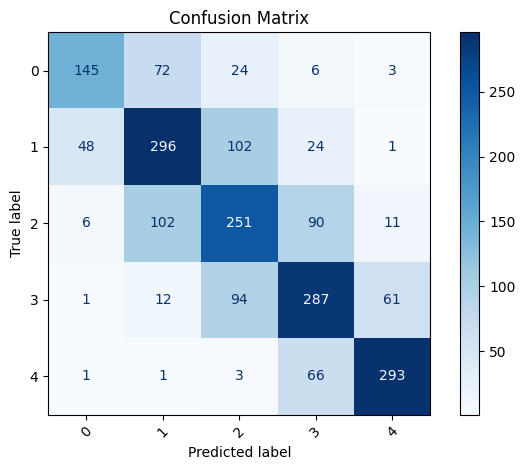

In [15]:

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)

plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


The voting ensemble model, which integrates LightGBM, HistGradientBoostingClassifier, and XGBoost, achieved a solid overall accuracy of 63.6%, with both macro and weighted F1-scores of 0.64. This indicates that the model performs consistently across all classes, without being overly biased toward any single category. Analyzing the class-wise performance, we see that class 0 reached an F1-score of 0.64, showing substantial improvement in recall (0.58) and precision (0.72), which were areas of concern in earlier models. Classes 1 and 3 both yielded stable F1-scores of 0.62, indicating balanced performance in mid-range property prices. Importantly, class 2, which had been challenging throughout development, achieved an F1-score of 0.54, showing that the ensemble was able to extract more signal from this ambiguous category. Class 4, representing the highest property price range, remained the strongest with an impressive F1-score of 0.80, supported by both high precision (0.79) and recall (0.80).

The confusion matrix further validates these outcomes: most predictions fall along the diagonal, showing that the model correctly classifies a majority of samples in each class. Misclassifications, where they occur, are largely concentrated between adjacent price ranges—such as class 1 misclassified as class 2 or class 0—indicating that the model is sensitive to subtle boundary shifts rather than systemic errors. Overall, this ensemble delivers a well-rounded and reliable multiclass classification solution that effectively balances predictive strength across both frequent and underrepresented property price categories.

2025/04/22 00:00:19 INFO mlflow.tracking.fluent: Experiment with name 'Property_Price_Ensemble' does not exist. Creating a new experiment.
2025/04/22 00:00:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ MLflow run completed at 2025-04-22 00:00:22
Logged to experiment: Property_Price_Ensemble


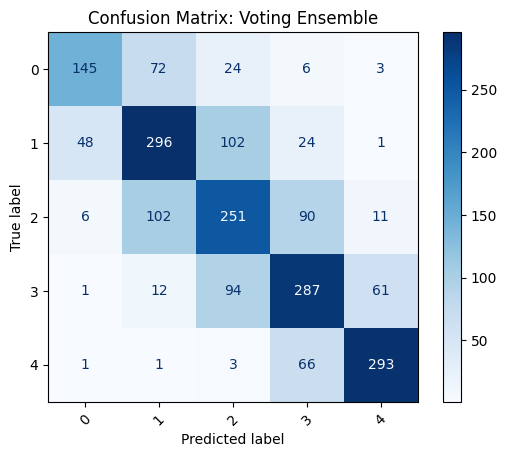

In [16]:
import mlflow
import mlflow.sklearn
import json
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from datetime import datetime
import os

# Set experiment with timestamped name to avoid overwrites
experiment_name = "Property_Price_Ensemble"
mlflow.set_experiment(experiment_name)

# Optional: Create folder for artifacts
os.makedirs("mlruns_artifacts", exist_ok=True)

# Start the run
with mlflow.start_run(run_name="VotingEnsemble_LGB_HistGB_XGB"):

    # === 1. Log Model Parameters ===
    mlflow.log_param("model_type", "VotingClassifier")
    mlflow.log_param("voting", "soft")
    mlflow.log_param("lgb_learning_rate", 0.1)
    mlflow.log_param("lgb_n_estimators", 200)
    mlflow.log_param("histgb_learning_rate", 0.05)
    mlflow.log_param("histgb_max_iter", 200)
    mlflow.log_param("xgb_learning_rate", 0.1)
    mlflow.log_param("xgb_max_depth", 5)

    # === 2. Train and Evaluate ===
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    # === 3. Log Evaluation Metrics ===
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("macro_f1", macro_f1)
    mlflow.log_metric("weighted_f1", weighted_f1)

    # === 4. Log the Trained Model Artifact ===
    mlflow.sklearn.log_model(ensemble_model, artifact_path="voting_ensemble_model")

    # === 5. Log Classification Report (JSON) ===
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_path = "mlruns_artifacts/classification_report.json"
    with open(report_path, "w") as f:
        json.dump(report_dict, f, indent=4)
    mlflow.log_artifact(report_path)

    # === 6. Log Confusion Matrix Plot ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix: Voting Ensemble")
    cm_path = "mlruns_artifacts/confusion_matrix.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)

    # === 7. Save Raw Predictions (Optional for Testing Audit) ===
    pred_df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred})
    pred_path = "mlruns_artifacts/predictions.csv"
    pred_df.to_csv(pred_path, index=False)
    mlflow.log_artifact(pred_path)

    print(f"✅ MLflow run completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Logged to experiment: {experiment_name}")
